# Activations and Gradients

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: Based on Building makemore Part 3: Activations & Gradients, BatchNorm by Andrej Karpathy. 
```

## Introduction

We dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: **Batch Normalization** {cite}`batchnorm`. Residual connections {cite}`resnet` and the Adam optimizer {cite}`adam` remain notable todos for later notebooks. 

## Preliminaries

For our experiments, we will use the model from our previous notebook.

In [7]:
import torch
import torch.nn.functional as F

import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
TRAIN_RATIO = 1.0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Still using the names dataset:

In [8]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:5]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [9]:
class CharDataset:
    def __init__(self, names, block_size):
        self.names = names
        self.vocab = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.vocab))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

Initializing our sequence dataset. Here we use the last three characters to predict the next character in a name:

In [10]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': xs.tolist(), 'ys': ys.tolist()})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(5)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.


Our previous character-based language model that passes embeddings to an MLP:

In [244]:
class MLP:
    def __init__(self, embedding_size, width, block_size, vocab_size=27, seed=2147483647):
        self.emb_size = embedding_size
        self.width = width
        self.blk_size = block_size
        self.vocab_size = vocab_size
        
        self.g  = torch.Generator().manual_seed(seed)
        self.C  = torch.randn(self.vocab_size, self.emb_size,              generator=self.g)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width), generator=self.g)
        self.b1 = torch.randn(self.width,                                  generator=self.g)
        self.W2 = torch.randn((self.width, self.vocab_size),               generator=self.g)
        self.b2 = torch.randn(self.vocab_size,                             generator=self.g)

        for p in self.parameters():
            p.requires_grad = True
    
    def parameters(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(x @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters():
           p.grad = None

Helper functions for training and evaluation:

In [378]:
from sklearn.model_selection import StratifiedKFold


def create_folds(xs, ys, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(xs.shape[0])
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
    xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
    xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

    return xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst


def train_step(model, xs_trn, ys_trn, generator, batch_size=32, lr=0.1):
    """One step of backprop and weight update using SGD."""
    
    B = torch.randint(0, xs_trn.shape[0], (batch_size,), generator=generator)
    logits = model(xs_trn[B])
    loss = F.cross_entropy(logits, target=ys_trn[B])

    model.zero_grad()
    loss.backward()
    for p in model.parameters():
        p.data -= lr * p.grad

    return loss.item()


def train_model(
        model,
        xs_trn, ys_trn,
        xs_dev, ys_dev,
        batch_size, num_steps, lr=0.1,
        verbose=True, seed=42,
    ):

    losses_trn = {}
    losses_dev = {}

    g = torch.Generator().manual_seed(seed)
    lr_counter = 0
    best_loss_dev = float("inf")
    print(f"Setting learning rate to {lr:.2e}")

    for k in range(num_steps):
        loss = train_step(model, xs_trn, ys_trn, g, batch_size, lr)
        losses_trn[k] = loss
        
        if (k % (num_steps // batch_size) == 0) or (k == num_steps - 1):
            with torch.no_grad():
                loss_dev = F.cross_entropy(model(xs_dev), ys_dev)
                losses_dev[k] = loss_dev.item()
            
            if verbose:
                print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]      loss={loss:<8.4f}    dev_loss={loss_dev:.4f}")
    
            if loss_dev.item() < best_loss_dev:
                best_loss_dev = loss_dev.item()
                lr_counter = 0
            else:
                lr_counter += 1
                if lr_counter == 3:
                    lr *= 0.1
                    lr_counter = 0
                    if verbose:
                        print(f"Decreasing learning rate to {lr:.2e}")
                    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev}

Reproducing results from previous notebook:

In [379]:
xs_trn, ys_trn, \
xs_dev, ys_dev, \
xs_tst, ys_tst = create_folds(xs, ys)

model = MLP(embedding_size=10, width=200, block_size=3)
hist = train_model(
    model, 
    xs_trn, ys_trn, 
    xs_dev, ys_dev, 
    batch_size=32, num_steps=200000, lr=0.1681999206544203,
    verbose=True
)

Setting learning rate to 1.68e-01
[000001/200000]      loss=25.8266     dev_loss=23.8420
[006251/200000]      loss=2.8457      dev_loss=2.6865


KeyboardInterrupt: 

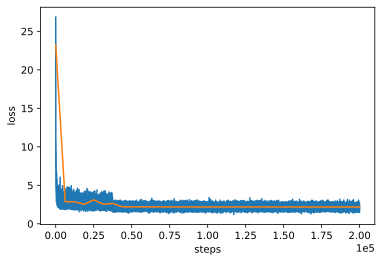

In [14]:
plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())))
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())))

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylabel("loss");

We will be keeping a results dict for monitoring our progress:

In [59]:
@torch.no_grad()
def split_loss(model, split: str):
    x, y = {
        'train': (xs_trn, ys_trn),
        'valid': (xs_dev, ys_dev),
        'test':  (xs_tst, ys_tst)
    }[split]
    loss = F.cross_entropy(model(x), y)
    return loss.item()


# dict for monitoring incremental progress
results = {}

def update_results(model, message):
    results[message] = {
        'train': split_loss(model, 'train'), 
        'valid': split_loss(model, 'valid')
    }

    print("train loss:", results[message]['train'])
    print("valid loss:", results[message]['valid'])


update_results(model, 'model')

train loss: 2.05999755859375
valid loss: 2.1155617237091064


## Initialization

In this section, we will look at the effect of **weight initialization** on training. Observe from the above graph that the loss starts very high during the start of training. This indicates poor initialization. From the network architecture and the problem setup, we generally have a rough idea of what loss to expect at initialization. In our example, the best possible loss at initialization is $-\log \frac{1}{27} = \log 27 \approx 3.2$ which assumes the predict probability to be uniform across the characters.

At initialization, we expect that the logits has zero mean since weights are initialized with zero mean. But we cannot expect the range of values to be small. For example, if the hidden layer before the logits is wide, then we expect that the spread of logits is high (e.g. positive values can stack). An important conseqence of this is that the larger the variance of the logits, the more the softmax approaches a one-hot vector. This can be seen in the following graph:

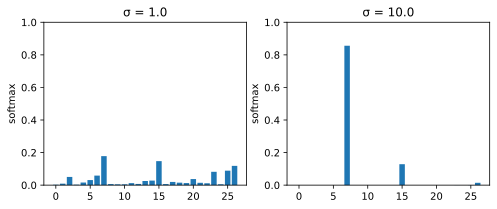

In [29]:
logits = torch.randn(size=(1, 27))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].bar(range(27), F.softmax(logits)[0]);
ax[1].bar(range(27), F.softmax(logits * 10)[0]);

ax[0].set_ylabel("softmax")
ax[0].set_ylim(0, 1)
ax[0].set_title("σ = 1.0")

ax[1].set_ylabel("softmax")
ax[1].set_ylim(0, 1)
ax[1].set_title("σ = 10.0");

Note that the model in the right plot is more likely to incur high penalty from the cross-entropy loss due to potentially being more confidently wrong. This can be the source of the high loss value at initialization.
Hence, we want to make sure to control the spread of values of the logits from its mean of zero. 

For the sake of fast experiment iterations, we refactor the above model so that we can initialize the linear layers separately. Observe that the linear layer takes in a `scale_fn` parameter which is a function of other layer parameters to control the standard deviation of the weights.

In [338]:
class Linear:
    def __init__(self, fan_in, fan_out, scale_fn, generator=None, bias=True, seed=0):
        self.g = generator if generator is not None else torch.Generator().manual_seed(seed)
        self.w = torch.randn((fan_in, fan_out), generator=self.g) * scale_fn(fan_in, fan_out)
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class MLP:
    def __init__(self, 
            embedding_size, width, block_size,
            scale_fn_hidden=lambda fan_in, fan_out: 1.0,
            scale_fn_logits=lambda fan_in, fan_out: 1.0,
            vocab_size=27, 
            seed=2147483647
        ):

        self.embedding_size = embedding_size
        self.width = width
        self.block_size = block_size
        self.vocab_size = vocab_size
        
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn(self.vocab_size, self.embedding_size, generator=self.g)
        self.h = Linear(block_size * embedding_size, width, scale_fn_hidden, seed=seed)
        self.tanh = Tanh()
        self.l = Linear(width, vocab_size, scale_fn_logits, seed=seed)        
        
        for p in self.parameters():
            p.requires_grad = True

    def parameters(self):
        return [self.C] + self.h.parameters() + self.l.parameters()

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.block_size * self.embedding_size)
        h_act = self.tanh(self.h(x))
        self.out = self.l(h_act)
        return self.out

    def zero_grad(self):
        for p in self.parameters():
           p.grad = None

Redefining the model to have low spread of values for the weights of the logits layer does the trick. You may be wondering if zeroing out the weights work. But this doesn't work due to symmetry in the structure of the MLP network. Such a model will learn the same number for the weights of the logits layer. Best is a combination of low values, along with some entropy for symmetry breaking.

In [224]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_fn_logits=lambda fan_in, fan_out: 0.01
)

hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=0.1681999206544203, verbose=False)
update_results(model, message='fix: logits')

Setting learning rate to 1.68e-01


KeyboardInterrupt: 

The network has the architecture as before but now starts with a good loss (around 3.2). In this case, instead of wasting training steps squashing the logits that are large during initialization, the model gets to focus on the hard gains during training. So the loss does not look too much like a hockey stick.

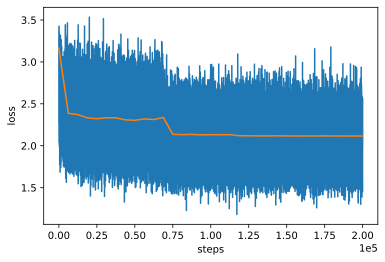

In [55]:
plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())))
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())))

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylabel("loss");

### Flat activation regions

The next thing we want to check is the activations in the hidden layer. Reinitializing the network (undoing training):

In [128]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_fn_logits=lambda fan_in, fan_out: 0.01
)

Passing one random mini batch:

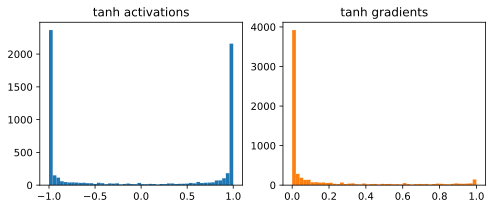

In [131]:
B = torch.randint(0, xs_trn.shape[0], (32,)) 
model(xs_trn[B])
h_act = model.tanh.out

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(h_act.reshape(-1).tolist(), bins=50, label='activations');
ax[1].hist((1 - h_act.reshape(-1)**2).tolist(), bins=50, color="C1", label='grads')
ax[0].set_title('tanh activations')
ax[1].set_title('tanh gradients');

This is due to large preactivations for tanh. If you are well-versed in the dark arts of backpropagation, you know that this is starting to look bad &mdash; the local gradients are zero for regions where tanh activation values saturate to $\pm 1.$ In fact, if we look at the histogram of local gradients of tanh, we can see that its mostly zero. 

This makes sense since in flat regions changing the input by a small amount does not change the tanh activations too much, and therefore has no impact on the loss. By extension, the corresponding weights and biases do not impact the loss, so that these parameters get zero gradient.

### Dead neurons

Another way to visualize this is as follows. Here white blocks indicate an activation where gradients are small. A dead neuron is a neuron that is mostly white over the training examples. Here this is indicated by a white column. This can occur not only for tanh but for other nonlinearities which has flat activation regions such as sigmoid or ReLU. Dead neurons can sometimes happen at initialization:

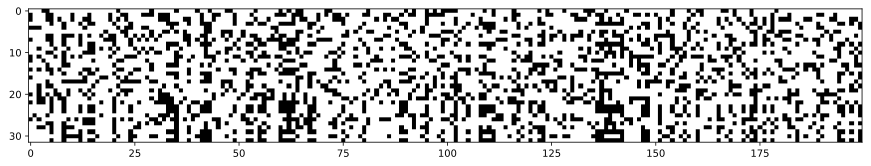

In [75]:
TANH_ACT_THRESHOLD = 0.97

plt.figure(figsize=(15, 3))
plt.imshow(h_act.abs() > TANH_ACT_THRESHOLD, cmap='gray');

This can also happen during training as shown here. For instance, a high learning rate results in neurons getting knocked off the data manifold. This means that from then on, no example activates this neuron, and this neuron remains dead forever. Sort of like a permanent brain damage in the network. Training with large learning rate:

In [76]:
learning_rate = 1.0 # (!) large learning rate
model = MLP(embedding_size=10, width=200, block_size=3, scale_fn_logits=lambda fan_in, fan_out: 0.01)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=learning_rate, verbose=False)

Setting learning rate to 1.00e+00


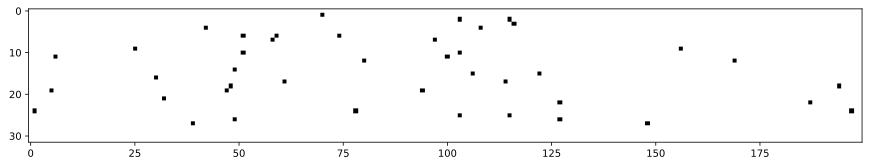

In [78]:
B = torch.randint(0, xs_trn.shape[0], (32,)) 
model(xs_trn[B])
h_act = torch.tanh(model.h.out)

plt.figure(figsize=(15, 3))
plt.imshow(h_act.abs() > TANH_ACT_THRESHOLD, cmap='gray');

### Fixing the saturated tanh

An easy way to fix saturated tanh is to simply reduce the range of values in the preactivation of the hidden layers.

In [132]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_fn_hidden=lambda fan_in, fan_out: 0.2,
    scale_fn_logits=lambda fan_in, fan_out: 0.01
)

Passing one mini-batch:

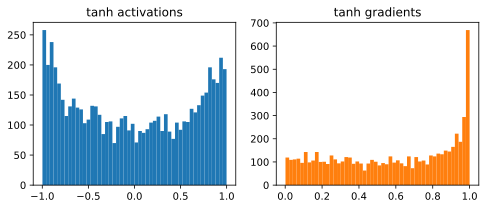

In [135]:
B = torch.randint(0, xs_trn.shape[0], (32,)) 
model(xs_trn[B])
h_act = model.tanh.out

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(h_act.reshape(-1).tolist(), bins=50);
ax[1].hist((1 - h_act.reshape(-1)**2).tolist(), bins=50, color="C1")
ax[0].set_title('tanh activations')
ax[1].set_title('tanh gradients');

By lowering preactivation values, we get tanh activation values that are not saturated. Consequently, we have more nonzero gradients. Full training with better initialization:

In [100]:
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=0.1681999206544203, verbose=False)
update_results(model, message='fix: tanh')

Setting learning rate to 1.68e-01


Results so far:

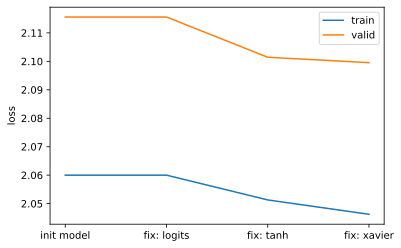

In [120]:
plt.plot(pd.DataFrame(results).loc['train'], label='train')
plt.plot(pd.DataFrame(results).loc['valid'], label='valid')
plt.ylabel('loss')
plt.legend();

### Calculating the init scale: Kaiming init

```{margin}
See {cite}`kaiming` or [this section](https://particle1331.github.io/fitter-happier-models/notebooks/tensorflow/04-tensorflow-optim-init.html#finding-appropriate-initialization-values) for a more formal derivation of results in this section.

Note that the scale factors for the weights can be difficult to choose optimally. Indeed, this is just to motivate the more precise initialization scheme that we will develop here. Observe that the output $\boldsymbol{\mathsf{y}} = \boldsymbol{\mathsf{x}}^\top \boldsymbol{\mathsf{w}}$ for $\boldsymbol{\mathsf{x}}, \boldsymbol{\mathsf{w}} \sim \mathcal{G}_{\mu=0, \sigma^2=1}$ starts to spread out. This makes sense since we are adding multiple terms equal to the width of the layer.

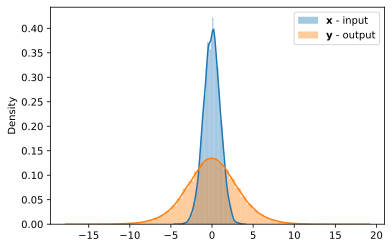

In [113]:
import seaborn as sns

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
sns.distplot(x.reshape(-1), color="C0", label='$\mathbf{x}$ - input');
sns.distplot(y.reshape(-1), color="C1", label='$\mathbf{y}$ - output');
plt.legend();

```{margin}
**Xavier init**
```

Ideally, we want the standard deviation of $\boldsymbol{\mathsf{y}}$ to be also $1$ to maintain stable activation flow. Otherwise, activations will recursively grow at each layer. This becomes increasingly problematic for deep networks. One straightforward fix is to initialize the weights $\boldsymbol{\mathsf{w}}$ with a distribution having $\sigma^2=\frac{1}{n}$ where $n$ is the length of $\boldsymbol{\mathsf{x}}.$ Note that setting the standard deviation turns out to be equivalent to just scaling the random variable with $\frac{1}{\sqrt{n}}$ (e.g. by linearity of expectation):

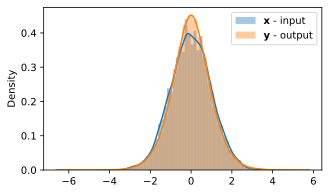

In [115]:
n = 10
x = torch.randn(1000, n)
w = torch.randn(n, 200) / n**0.5
y = x @ w

plt.figure(figsize=(5, 3))
sns.distplot(x.reshape(-1), color="C0", label='$\mathbf{x}$ - input');
sns.distplot(y.reshape(-1), color="C1", label='$\mathbf{y}$ - output');
plt.legend();

```{margin}
**Kaiming init**
```

This looks nice! To account for nonlinear activations, we need to use a different standard deviation for the weights. ReLU activation discards half of the input distribution, so to compensate $\sigma^2= \frac{2}{n}$ is used {cite}`kaiming`. The factor 2 called [gain](https://pytorch.org/docs/stable/nn.init.html) accounts for the **squashing effect** of the activations. This effect compounds as we train deeper networks. The gain for tanh is $\frac{5}{3}.$ Applying this to our network:

In [117]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_fn_hidden=lambda fan_in, fan_out: (5 / 3) / (fan_in ** 0.5),
    scale_fn_logits=lambda fan_in, fan_out: 0.01
)

hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=0.1681999206544203, verbose=False)
update_results(model, message="fix: xavier")

Setting learning rate to 1.68e-01
train loss: 2.0462427139282227
valid loss: 2.099531650543213


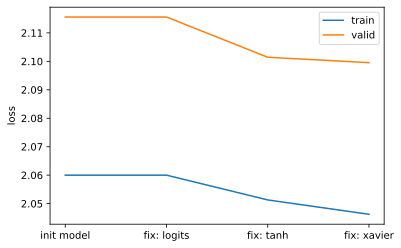

In [119]:
plt.plot(pd.DataFrame(results).loc['train'], label='train')
plt.plot(pd.DataFrame(results).loc['valid'], label='valid')
plt.ylabel('loss')
plt.legend();

The last improvement here is probably just due to randomness. But what is important is that we now have a semi-principled approach to initializing the weights instead of using arbitrary factors. This will serve as sort of a guide to scale us to much bigger and deeper networks. 

**Remarks.** Gradients also need to have stable flow across the layers. It turns out that for a linear layer $\sigma^2=\frac{1}{m}$ works where $m$ is the number of output neurons. This makes sense since gradients flow in the reverse direction. To include the constraints in both directions, we can use the harmonic mean $\sigma^2=\frac{2}{n + m}.$ 

## Batch Normalization

We went quickly through the weight initialization schemes. This was intentional. Before when {cite}`kaiming` came out, practitioners needed to be really careful with activation and gradient ranges and histograms, as well as the precise setting of gains and the nonlinearities used. Everything was finicky and fragile, and very properly arranged for the neural net to train. This is especially true for very deep networks. Modern innovations that made everything more stable, so that there is no need to initialize exactly right:

- Residual connections {cite}`resnet`
- Normalization layers (BatchNorm {cite}`batchnorm`, LayerNorm {cite}`layernorm`, GroupNorm {cite}`groupnorm`)
- Better optimizers ([RMSProp](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), Adam {cite}`adam` = neural net cheat code)

Batch Normalization was extremely impactful when it came out in 2015. It made it possible to train very deep nets quite reliably. It basically just works™. The idea of the BatchNorm layer is that if we want preactivations to be roughly Gaussian, then we can just normalize them along the mini-batch. Turns out this operation is differentiable! 🤯

But using only normalization will not give you good results as this severely limits the expressivity of the neurons. We want the distributions to be unit Gaussian only at initialization.  As the network learns, we want backpropagation to move the distributions around so that the neurons learn more varied activation patterns. Hence, the paper introduced two **learnable parameters** that control the scale and shift of each neuron:

```{figure} ../../img/batchnorm-algo1.png
---
width: 400px
name: batchnorm-algo1
---

```

<br>

**Remark.** Note that we will not try to use BatchNorm on our previous language model. This results in little improvement since the network is small and shallow. Here BatchNorm is not doing much. For example, we already know gain for the tanh layer. Performance is likely not bottlenecked by the optimization, but by block size.

For deeper networks with more complex operations, e.g. residual connections or convolutions, it will become very difficult to tune the scales of the weight matrices such that all
activations are roughly Gaussian. The math very quickly becomes intractable.
It is much much easier in practice to just sprinkle BatchNorm layer. This technique just works generically for any new layer that we introduce in the future.

### Implementation

In this section, we will discuss implementation details. Observe that we will append BatchNorm after linear layers. This allows the parameters of BatchNorm to be folded into the linear layers, making it more efficient during inference. Note also that the bias on linear layers can now be removed (i.e. set to `bias=False`) since normalization will subtract these out anyway. This is compensated by the bias of the BatchNorm layer.

In [293]:
class BatchNorm1d:
    def __init__(self, width, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop); init x̂ ~ G(0, 1)
        self.gamma = torch.ones(width)
        self.beta = torch.zeros(width)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(width)
        self.running_var  = torch.ones (width)

    def __call__(self, x):
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var  = x.var (0, keepdim=True)

            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * x_var
        else:
            x_mean = self.running_mean
            x_var  = self.running_var

        xhat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

### BatchNorm = Bad

The benefits of Batch Normalization come at a huge cost: our mini batches are now coupled mathematically during forward and backward pass. Although this has a nice regularization effect by adding some noise on the training example as a result of the other examples in the batc, this turns out to be really bug prone. We want to avoid Batch Normalization as much as possible. There are more recent normalization techniques in deep learning that do not have this coupling issue {cite}`groupnorm` {cite}`layernorm`.

## Training a deeper network

Here we will train a deep network. To do this, we simply introduce a `layers` argument that will contain the layers of the MLP that processes embeddings.

In [344]:
class DeepMLP:
    def __init__(self, embedding_size, block_size, layers, vocab_size, seed=2147483647):

        self.embedding_size = embedding_size
        self.block_size = block_size
        self.vocab_size = vocab_size
        
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn(self.vocab_size, self.embedding_size, generator=self.g)
        self.layers = layers     
        
        for p in self.parameters():
            p.requires_grad = True

    def parameters(self):
        return [self.C] + [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, xs: list[int]):
        self.out = self.C[xs].view(-1, self.block_size * self.embedding_size)
        for layer in self.layers:
            self.out = layer(self.out)
        return self.out

    def zero_grad(self):
        for p in self.parameters():
           p.grad = None

We want to monitor training, so we define a new training function. This retains the gradient of output tensors which are non-leaf. PyTorch, by default, discards these gradients.

In [387]:
def monitor_train_model(
        model,
        xs_trn, ys_trn,
        xs_dev, ys_dev,
        batch_size, num_steps, lr=0.1,
        verbose=True, seed=42,
    ):

    losses_trn = {}
    ud = []

    g = torch.Generator().manual_seed(seed)
    print(f"Setting learning rate to {lr:.2e}")

    for k in range(num_steps):

        B = torch.randint(0, xs_trn.shape[0], (batch_size,), generator=g)
        logits = model(xs_trn[B])
        loss = F.cross_entropy(logits, target=ys_trn[B])

        model.zero_grad()
        for layer in model.layers:
            layer.out.retain_grad()

        loss.backward()
        for p in model.parameters():
            p.data -= lr * p.grad
        
        losses_trn[k] = loss.item()

        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])
                    
    return {"loss_trn": losses_trn, "loss_dev": [], "ud": ud}

Note that it can also help to apply Batch Normalization on the logits:

In [388]:
block_size = 3
embedding_size = 10
vocab_size = 27
width = 100
xavier_tanh = lambda fan_in, fan_out: (5 / 3) / (fan_in ** 0.5)
xavier = lambda fan_in, fan_out: 1 / (fan_in ** 0.5) # make logits small

layers_bn = [
    Linear(embedding_size * block_size, width, scale_fn=xavier_tanh), BatchNorm1d(width), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), BatchNorm1d(width), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), BatchNorm1d(width), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), BatchNorm1d(width), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), BatchNorm1d(width), Tanh(),
    Linear(width, vocab_size, scale_fn=xavier), BatchNorm1d(vocab_size) 
]

model_bn = DeepMLP(embedding_size, block_size, layers_bn, vocab_size)
hist_bn = monitor_train_model(model_bn, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=1000, lr=0.1, verbose=True)

Setting learning rate to 1.00e-01


For comparison, let's train the same network model without BatchNorm:

In [394]:
layers = [
    Linear(embedding_size * block_size, width, scale_fn=xavier_tanh), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), Tanh(),
    Linear(width, width, scale_fn=xavier_tanh), Tanh(),
    Linear(width, vocab_size, scale_fn=xavier)
]

model = DeepMLP(embedding_size, block_size, layers, vocab_size)
hist = monitor_train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=1000, lr=0.1, verbose=True)

Setting learning rate to 1.00e-01


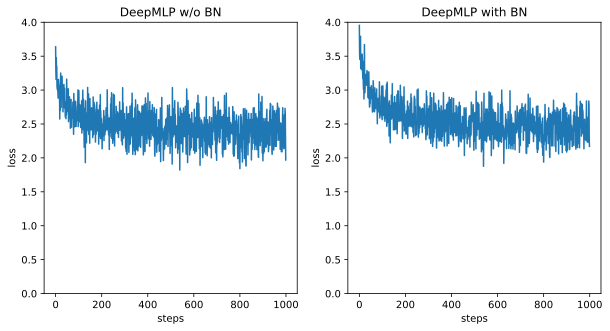

In [364]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())))
ax[0].plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())))
ax[0].set_xlabel("steps")
ax[0].set_ylabel("loss");
ax[0].set_ylim(0, 4)
ax[0].set_title("DeepMLP w/o BN")

ax[1].plot(hist_bn['loss_trn'].keys(), torch.tensor(list(hist_bn['loss_trn'].values())))
ax[1].plot(hist_bn['loss_dev'].keys(), torch.tensor(list(hist_bn['loss_dev'].values())))
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].set_title("DeepMLP with BN")
ax[1].set_ylim(0, 4);

Observe that the loss curve is more stable for the deep MLP with BatchNorm.

### Activation

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.00%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.62%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 2.62%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 2.06%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 1.94%


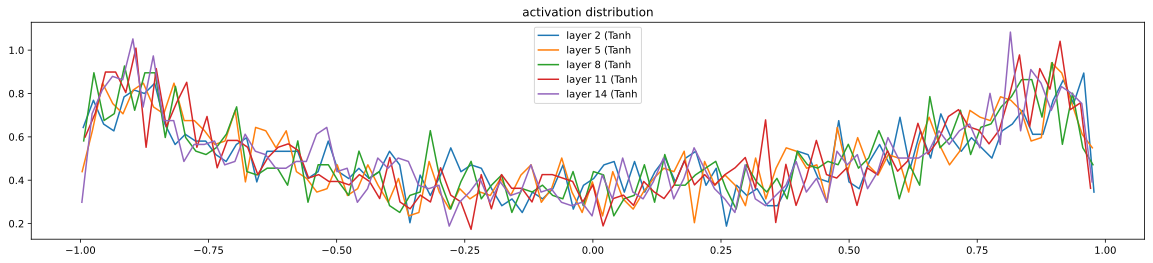

In [372]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model_bn.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > TANH_ACT_THRESHOLD).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.09%
layer 3 (      Tanh): mean +0.02, std 0.72, saturated: 13.34%
layer 5 (      Tanh): mean -0.08, std 0.72, saturated: 12.62%
layer 7 (      Tanh): mean +0.08, std 0.72, saturated: 12.34%
layer 9 (      Tanh): mean -0.04, std 0.71, saturated: 10.03%


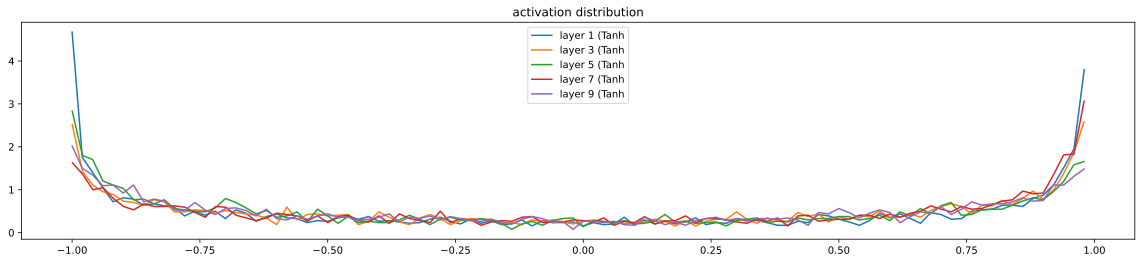

In [371]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > TANH_ACT_THRESHOLD).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

### Output gradients

layer 1 (      Tanh): mean -0.000077, std 3.800627e-03
layer 3 (      Tanh): mean -0.000008, std 3.558143e-03
layer 5 (      Tanh): mean +0.000063, std 3.269891e-03
layer 7 (      Tanh): mean -0.000113, std 3.136271e-03
layer 9 (      Tanh): mean +0.000044, std 2.957948e-03


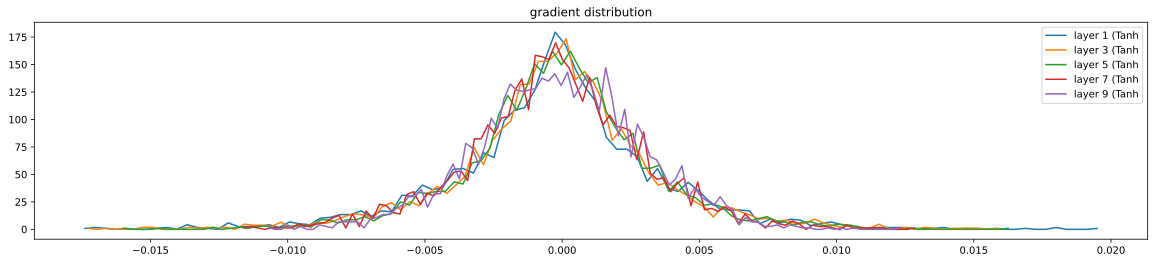

In [373]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

layer 2 (      Tanh): mean -0.000000, std 3.639979e-03
layer 5 (      Tanh): mean -0.000000, std 2.979081e-03
layer 8 (      Tanh): mean +0.000000, std 2.670739e-03
layer 11 (      Tanh): mean +0.000000, std 2.422947e-03
layer 14 (      Tanh): mean -0.000000, std 2.187218e-03


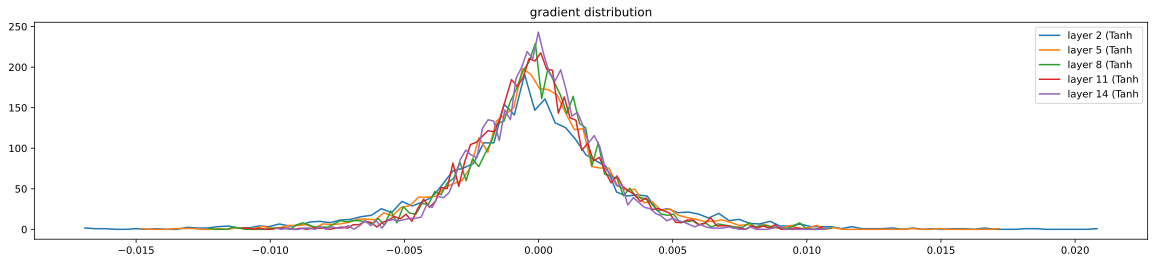

In [374]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model_bn.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

### Weight gradients

weight   (27, 10) | mean +0.001269 | std 1.203333e-02 | grad:data ratio 1.202882e-02
weight  (30, 100) | mean +0.000397 | std 1.222047e-02 | grad:data ratio 3.983112e-02
weight (100, 100) | mean -0.000014 | std 9.258917e-03 | grad:data ratio 5.461283e-02
weight (100, 100) | mean -0.000025 | std 8.350082e-03 | grad:data ratio 4.938085e-02
weight (100, 100) | mean +0.000191 | std 7.910953e-03 | grad:data ratio 4.690896e-02
weight (100, 100) | mean -0.000035 | std 7.394771e-03 | grad:data ratio 4.408268e-02
weight  (100, 27) | mean +0.000000 | std 2.132510e-02 | grad:data ratio 1.999441e-01


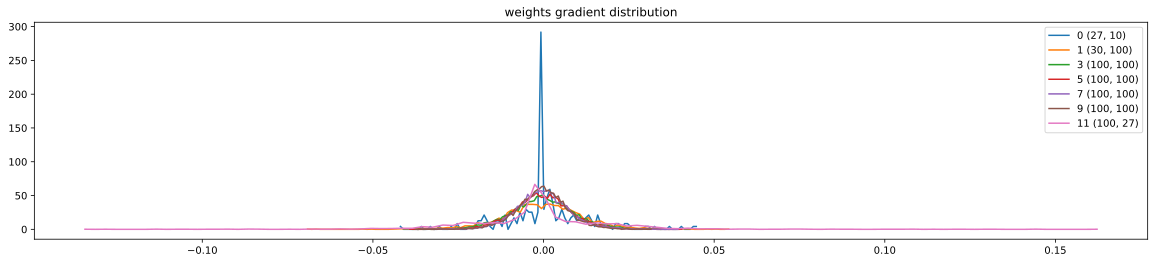

In [375]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

weight   (27, 10) | mean +0.000000 | std 9.860730e-03 | grad:data ratio 9.848263e-03
weight  (30, 100) | mean +0.000014 | std 8.712360e-03 | grad:data ratio 2.843318e-02
weight (100, 100) | mean +0.000024 | std 6.760176e-03 | grad:data ratio 4.011690e-02
weight (100, 100) | mean +0.000034 | std 5.756800e-03 | grad:data ratio 3.424339e-02
weight (100, 100) | mean -0.000016 | std 4.876456e-03 | grad:data ratio 2.904365e-02
weight (100, 100) | mean +0.000011 | std 4.363569e-03 | grad:data ratio 2.601384e-02
weight  (100, 27) | mean -0.000019 | std 1.177933e-02 | grad:data ratio 1.068100e-01


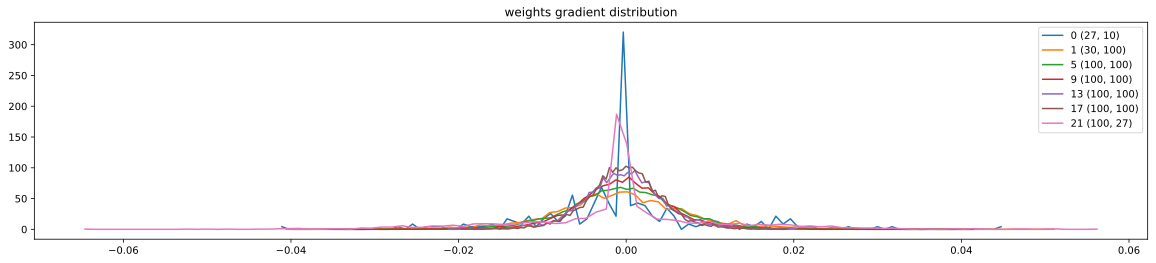

In [376]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model_bn.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

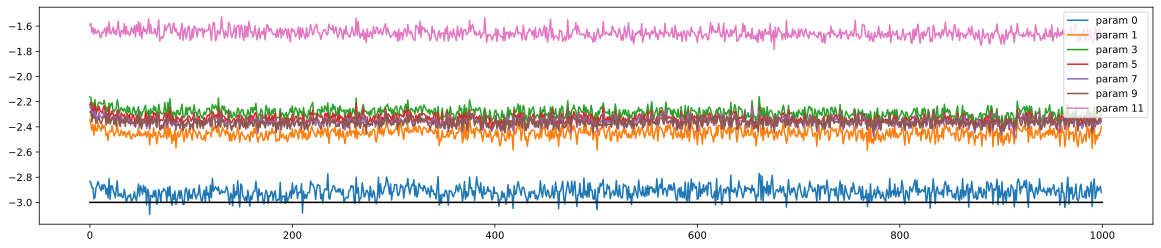

In [395]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([hist['ud'][j][i] for j in range(len(hist['ud']))])
    legends.append('param %d' % i)
plt.plot([0, len(hist['ud'])], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

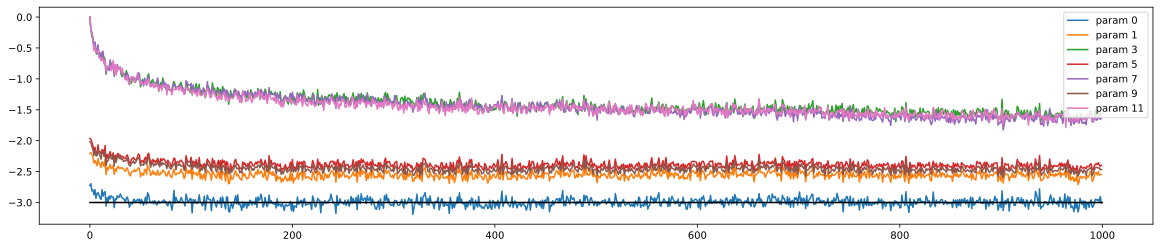

In [396]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([hist_bn['ud'][j][i] for j in range(len(hist_bn['ud']))])
    legends.append('param %d' % i)
plt.plot([0, len(hist_bn['ud'])], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

also look at data ratio. also look at improvement with training. can be done by mean +- std curve vs step (x axis)?

also look lr * p.grad.std() / p.data.std() (range from zero, i.e. magnitude). should be ~1e-3. otherwise too large updates.
Not too much above. Or way below. Or discrepancy between layers. 

last layer less confident at init -> very high ratio for last layer. should stabilize over time. 

add bn layers after linear. check improvement. also ok to add bn after logits.

can change gain, but learning rate will have to be calibrated.

is neural net in a good state dynamically. updates over time.